Define Utilities for code to use 

In [ ]:
import numpy as np 
from PIL import Image
import base64
from io import BytesIO
import matplotlib.pyplot as plt
def apply_arcsinh_scaling(data, scale_factor=0.90):
    # Normalize the data to [0, 1]
    data = data - np.min(data)  # Shift data to start from 0

    # Apply arcsinh scaling
    scaled_data = np.arcsinh(scale_factor * data)

    # Normalize again to [0, 255] for image encoding
    scaled_data = scaled_data / np.max(scaled_data)  # Normalize to [0, 1]
    scaled_data = (scaled_data * 255).astype(np.uint8)  # Convert to 8-bit
    return scaled_data

def encode_image_to_base64(data, scale_factor=0.01):
    """
    Apply arcsinh scaling and encode the image as Base64.
    """
    # Apply arcsinh scaling
    scaled_data = apply_arcsinh_scaling(data, scale_factor)
    # Convert scaled data to an image
    image = Image.fromarray(scaled_data)
    image = image.resize((128,128), Image.Resampling.LANCZOS)
    # Save the image to a BytesIO object
    buffered = BytesIO()
    image.save(buffered, format="PNG")

    # Encode the BytesIO object as Base64
    base64_image = base64.b64encode(buffered.getvalue()).decode("utf-8")
    return base64_image

Create a json file containing the images that will be sent in batches to the API

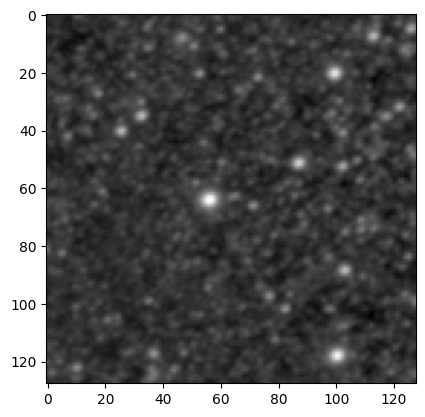

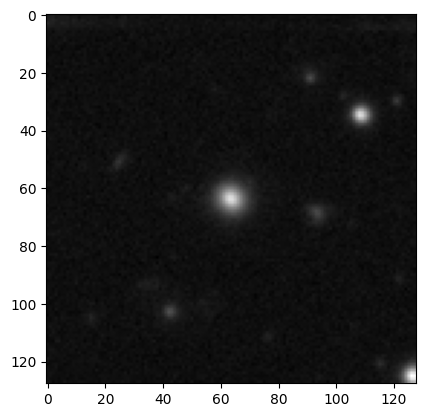

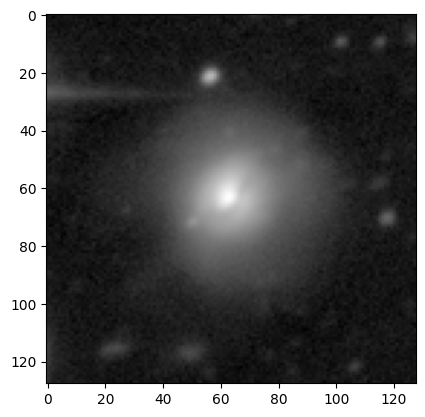

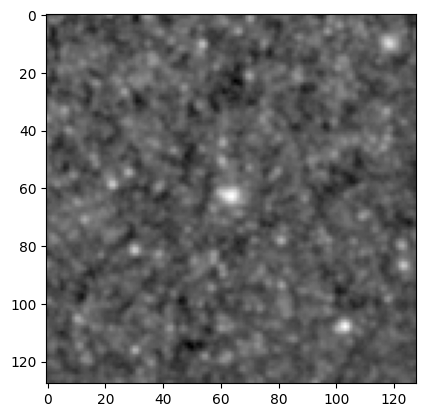

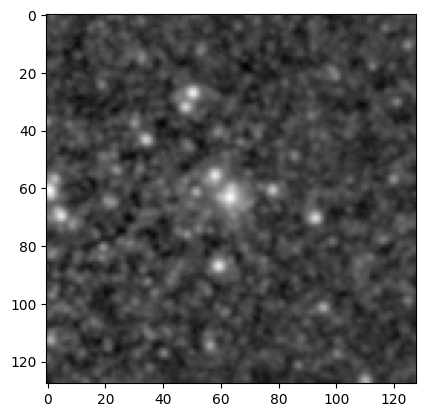

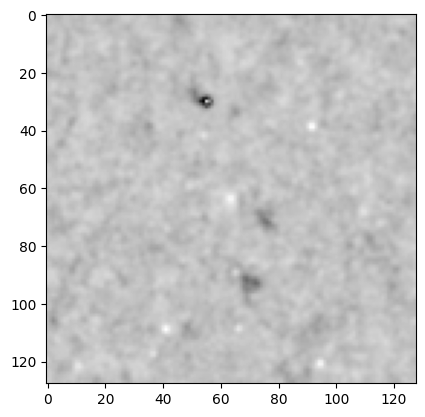

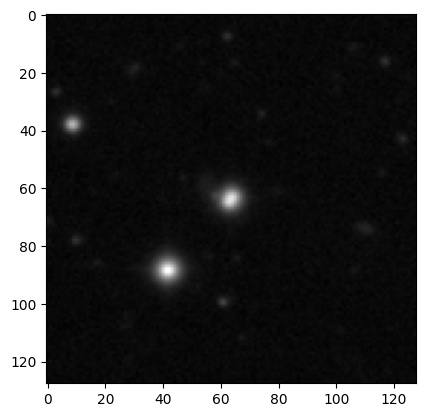

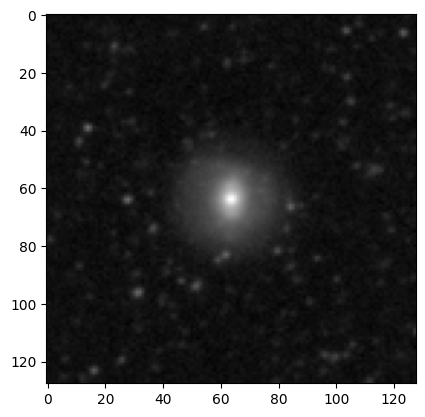

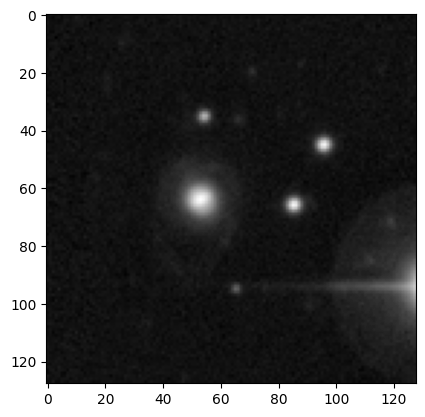

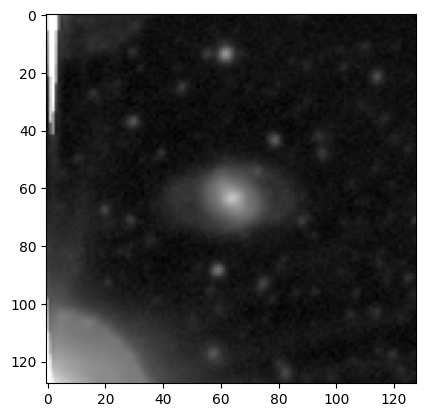

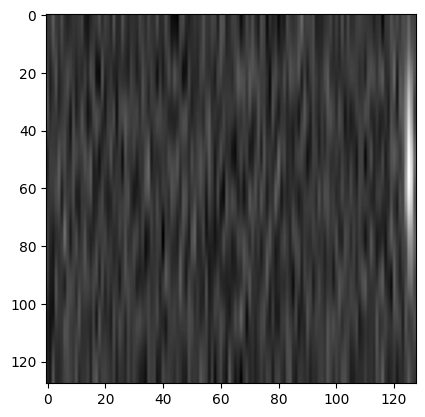

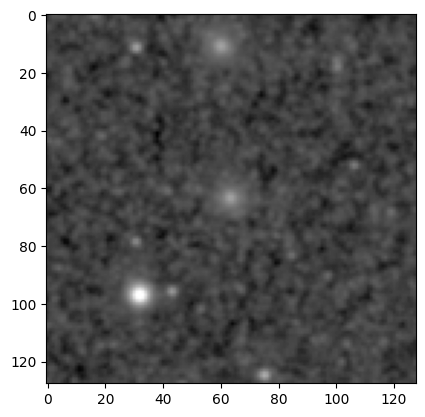

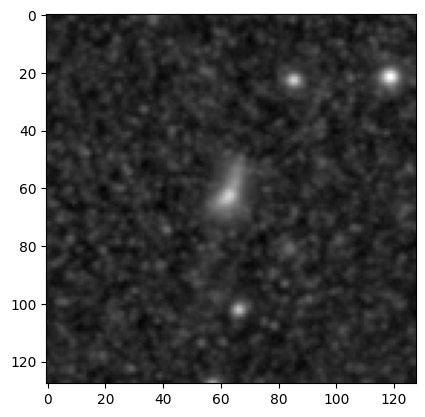

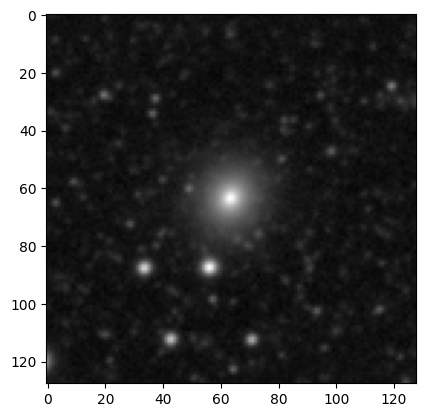

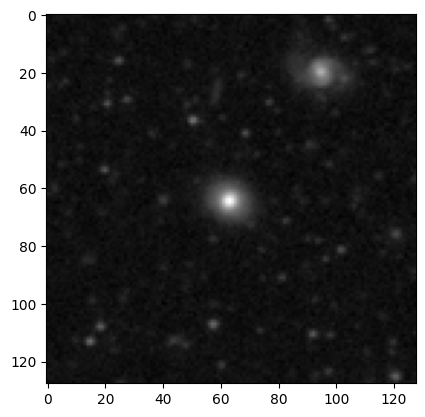

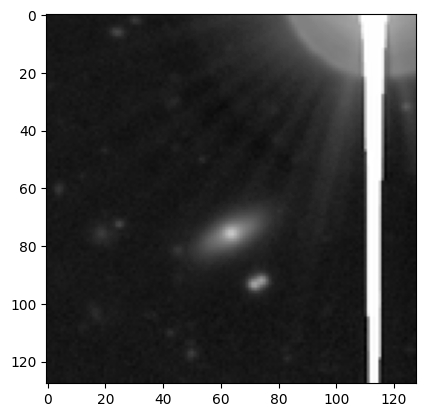

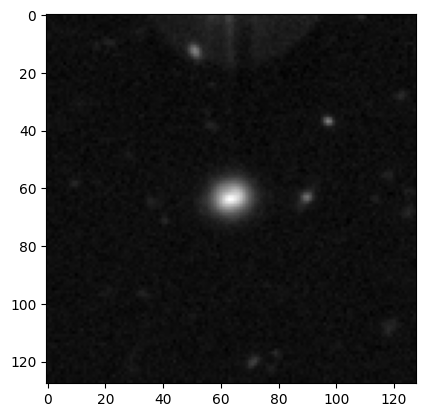

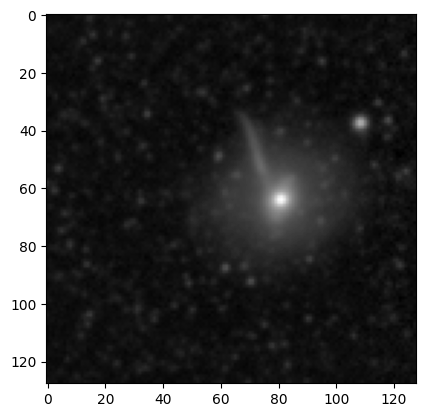

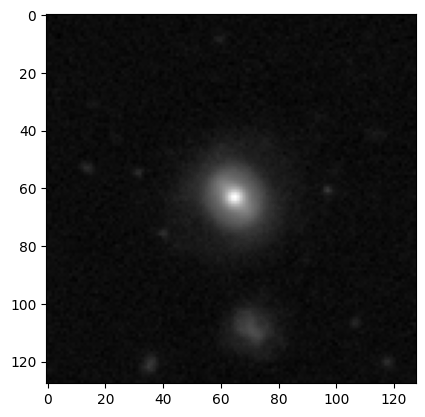

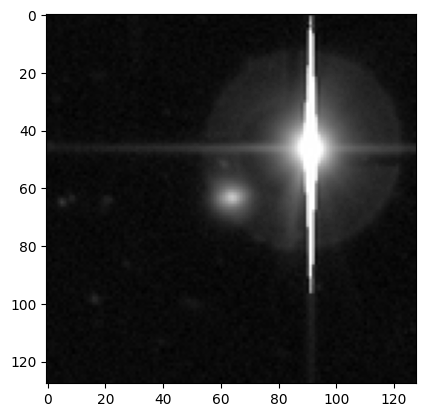

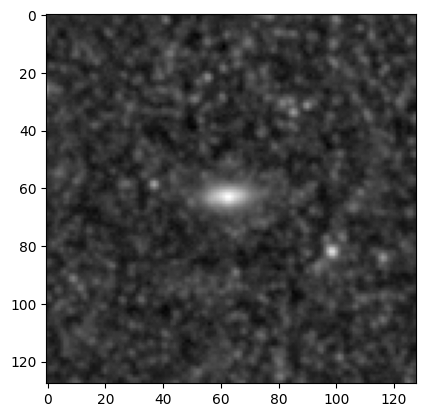

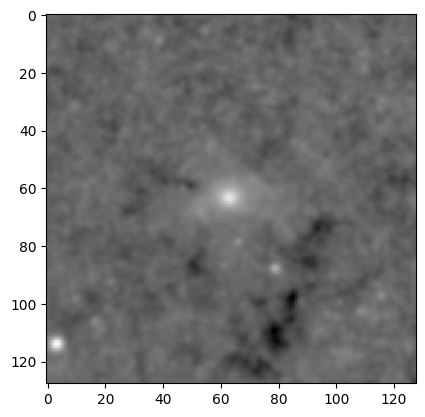

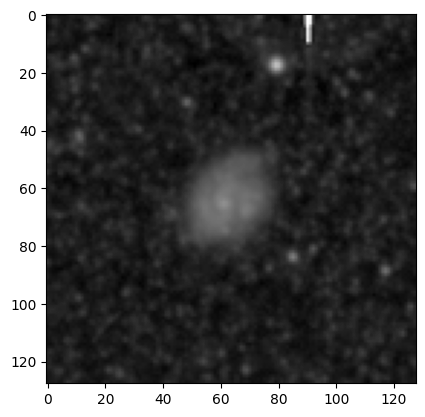

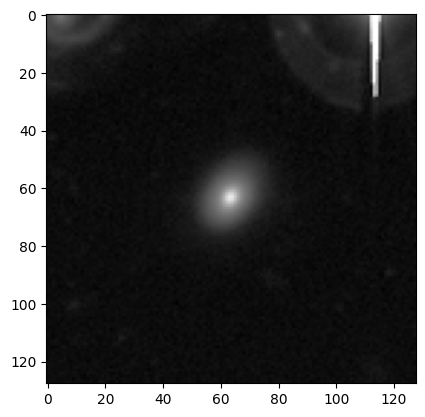

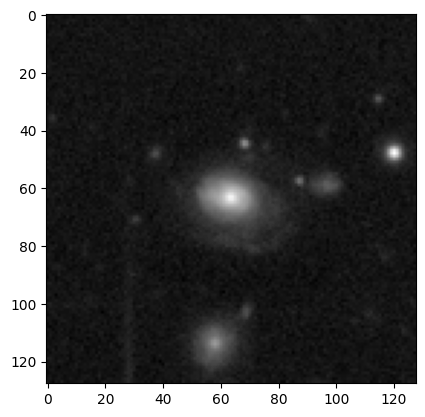

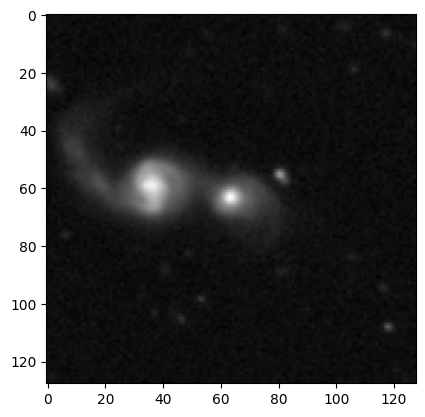

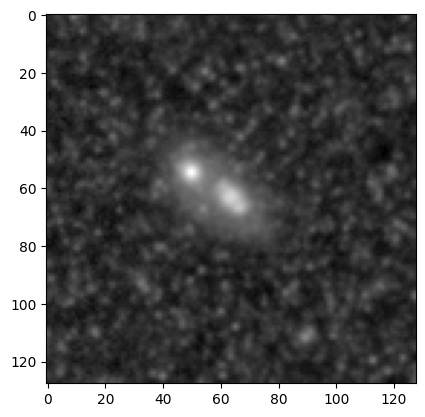

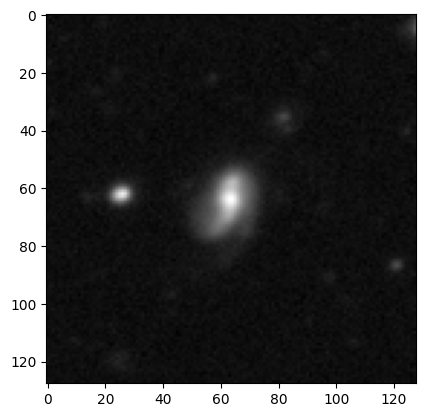

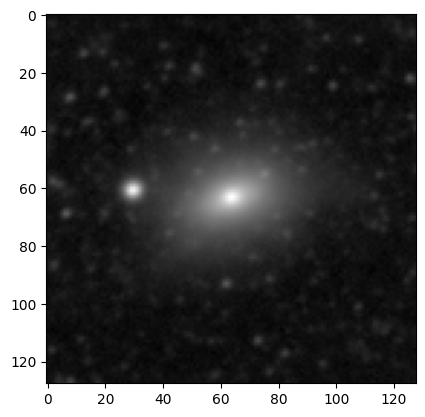

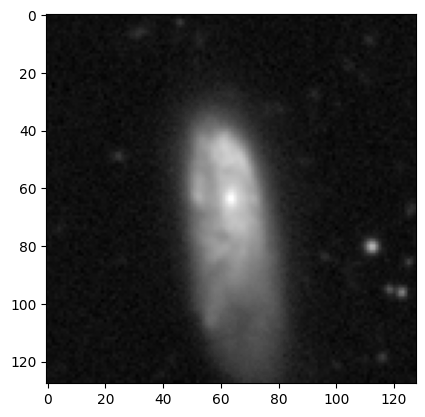

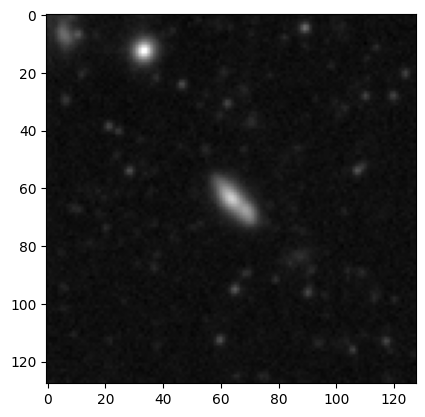

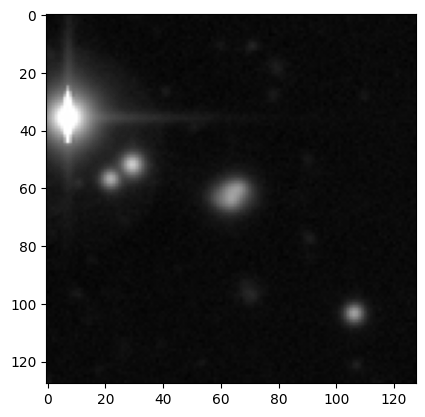

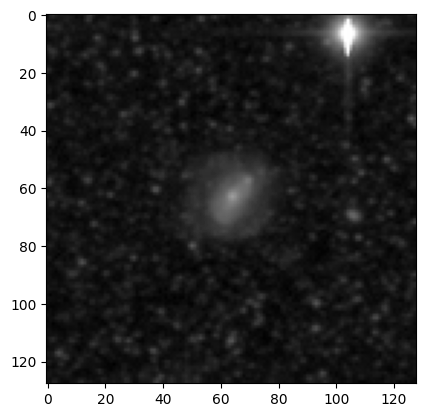

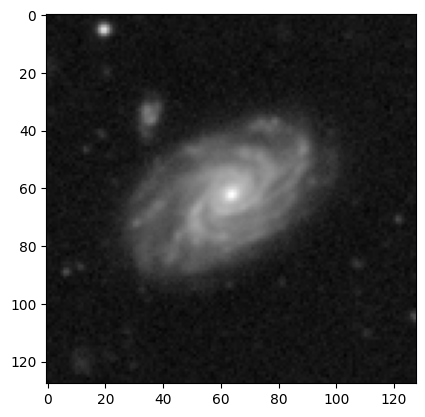

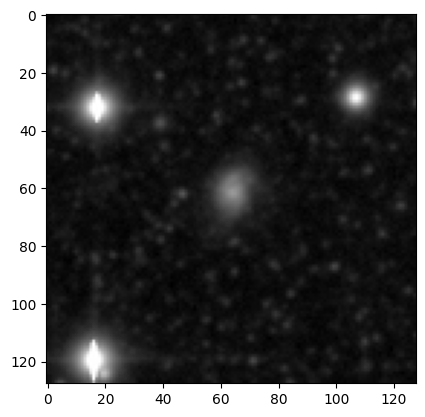

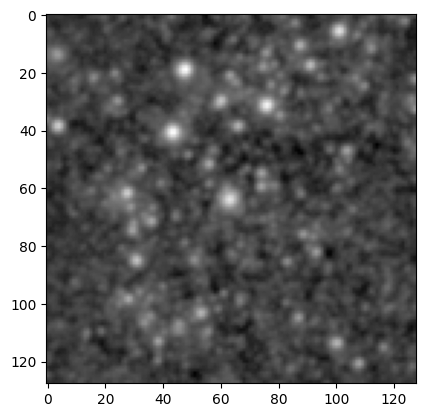

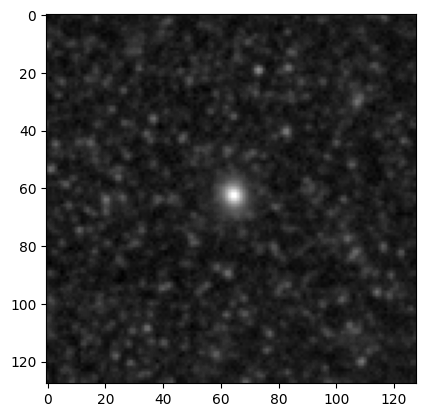

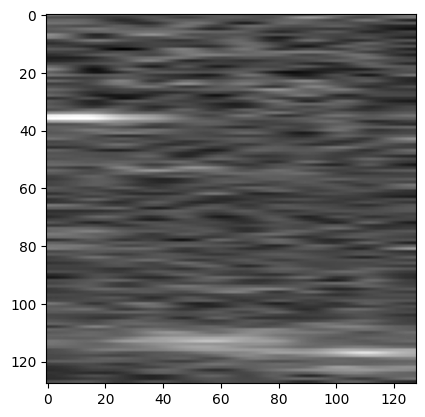

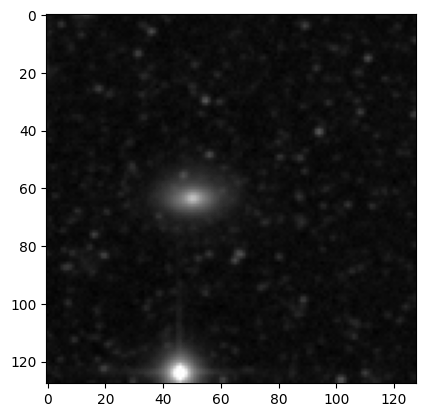

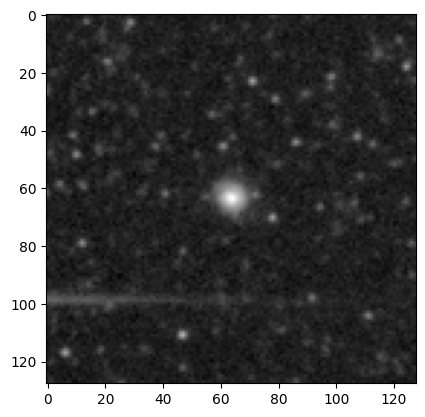

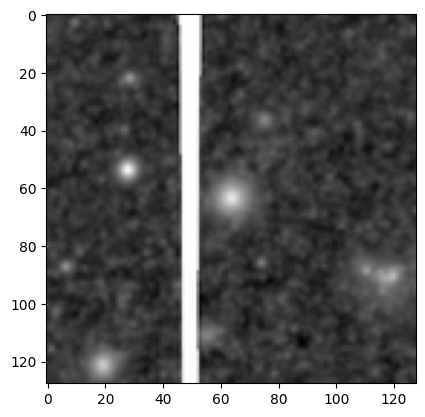

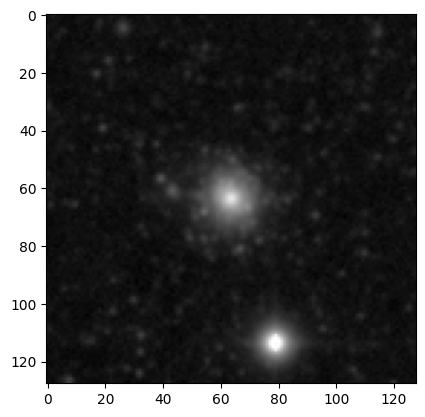

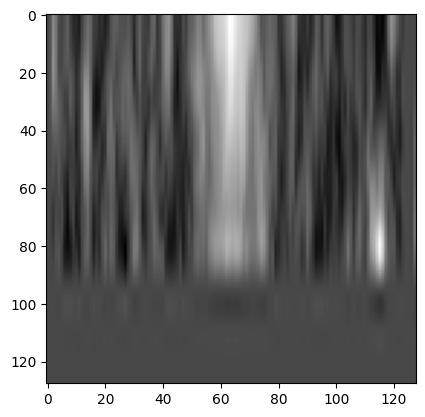

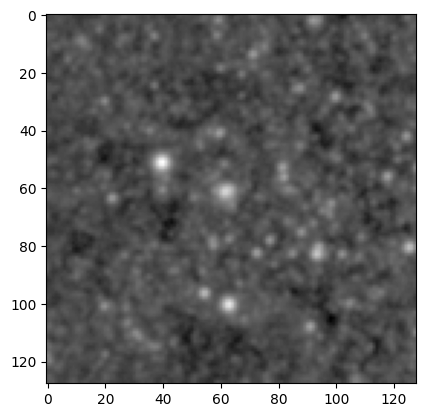

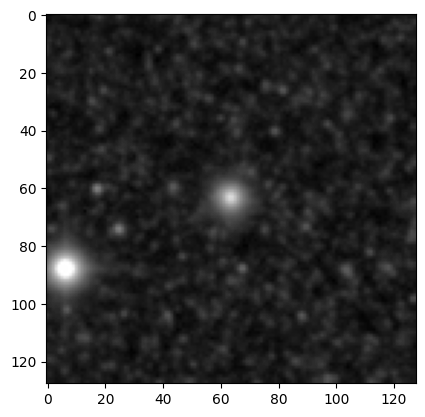

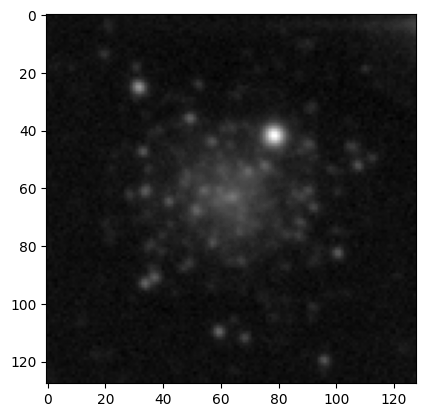

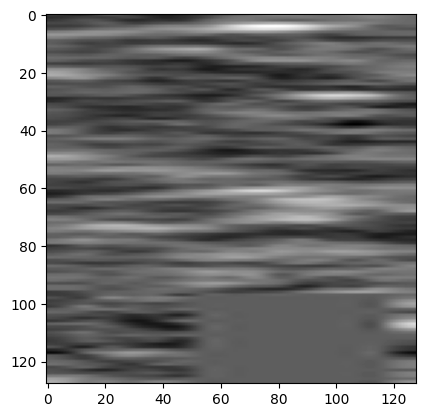

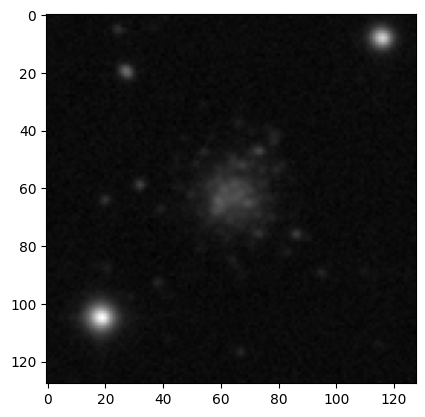

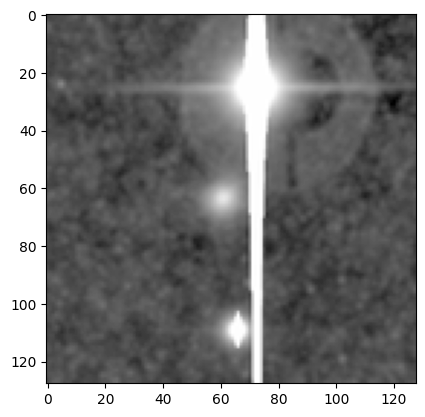

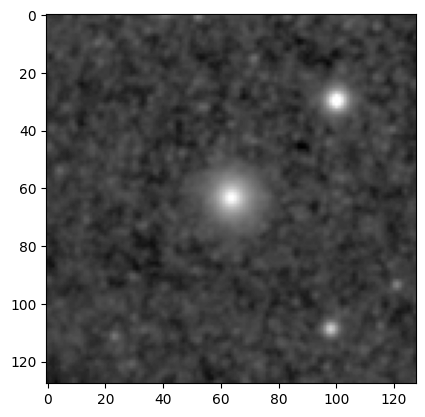

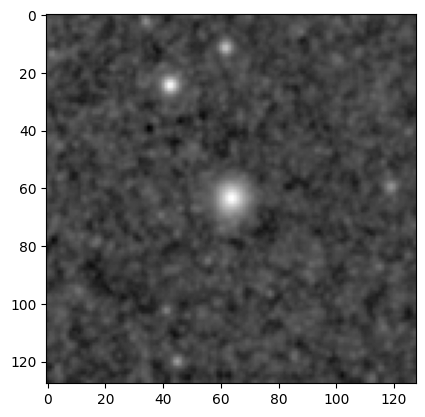

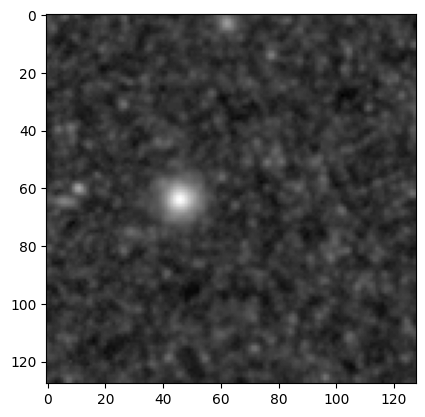

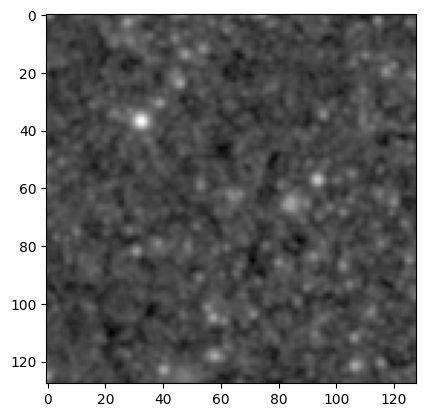

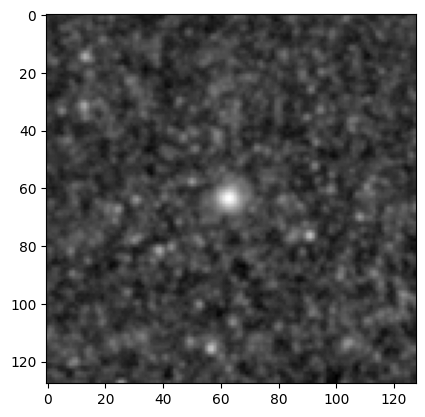

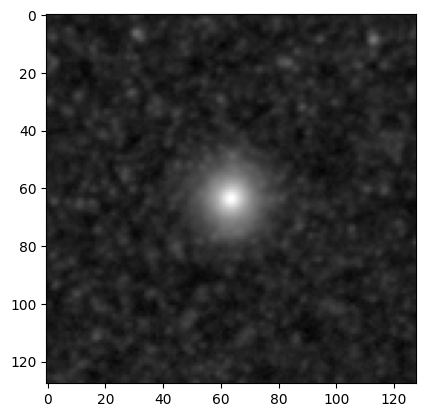

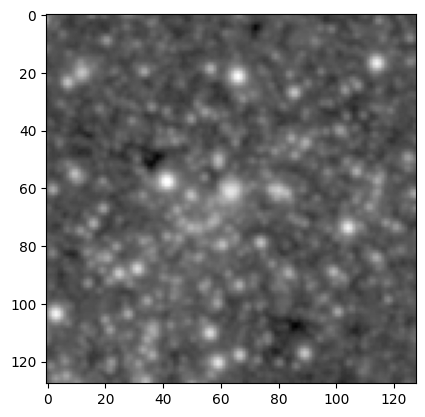

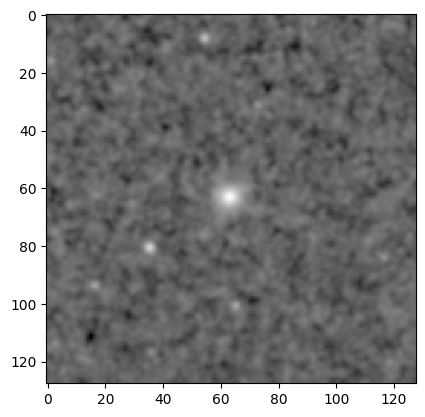

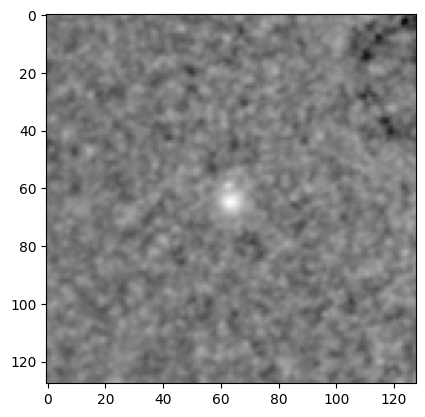

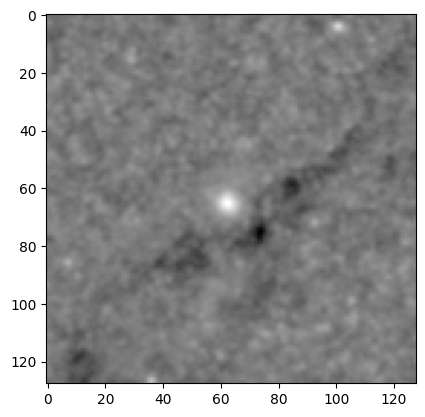

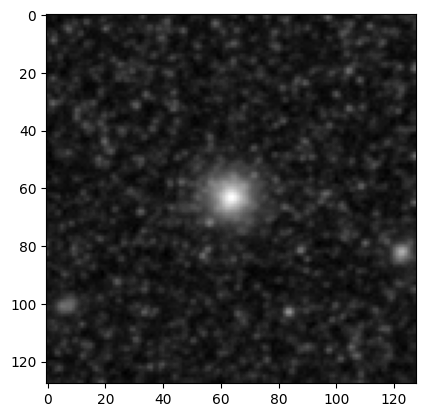

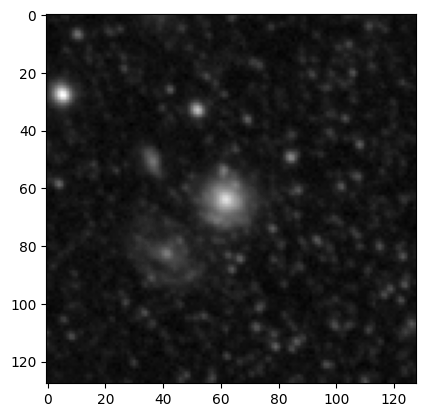

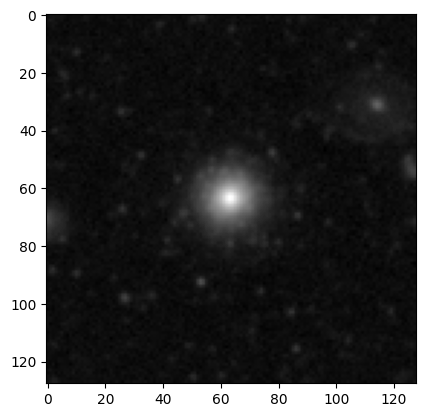

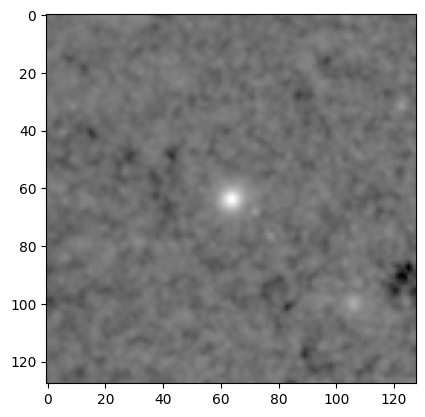

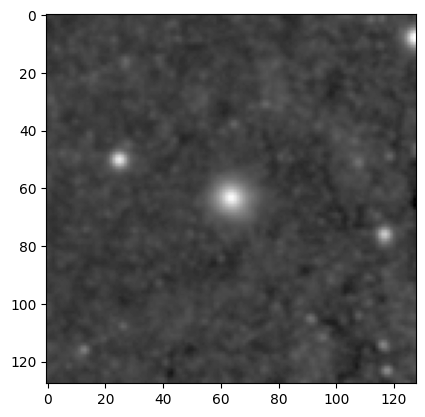

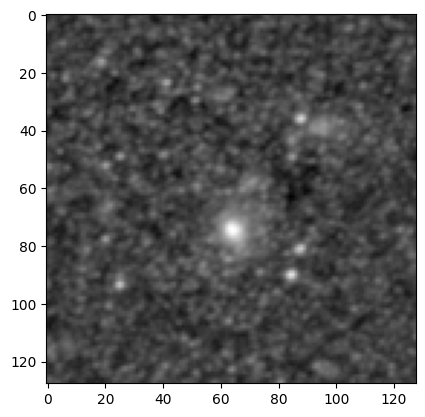

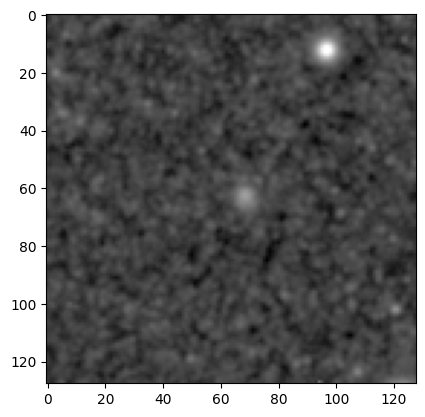

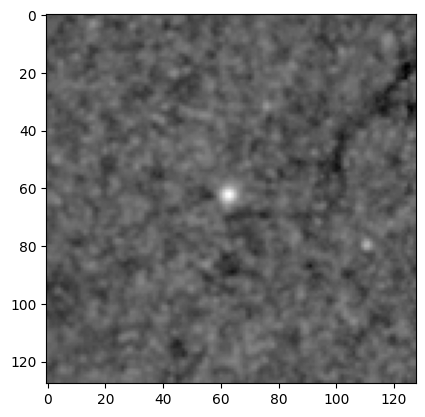

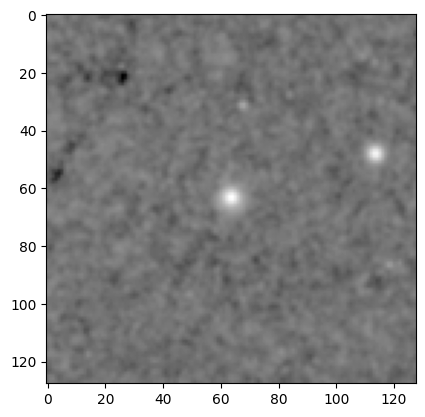

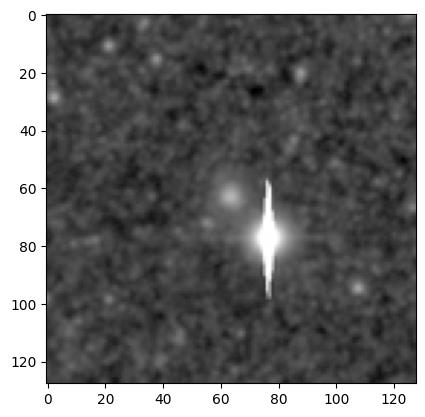

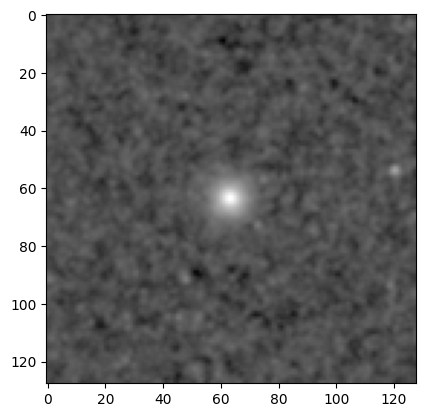

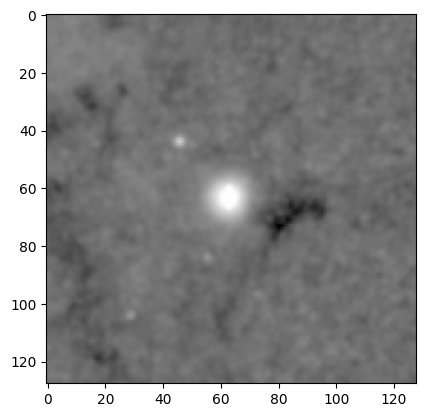

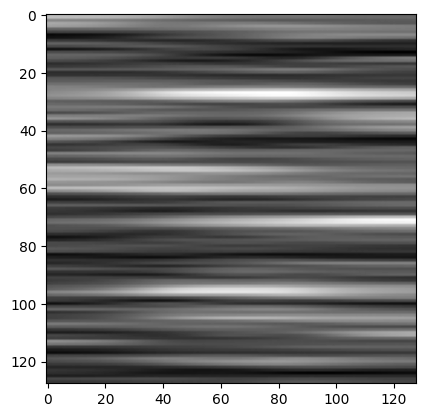

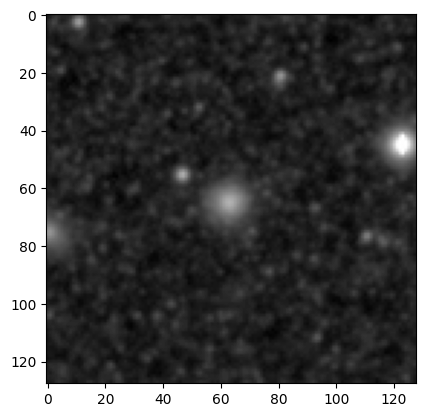

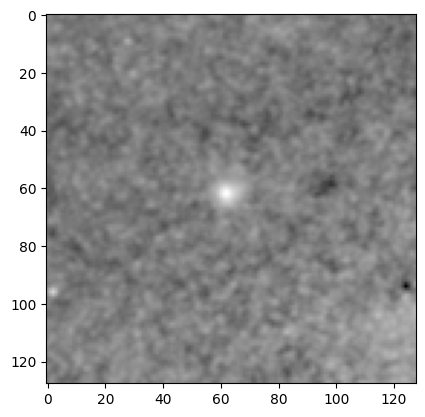

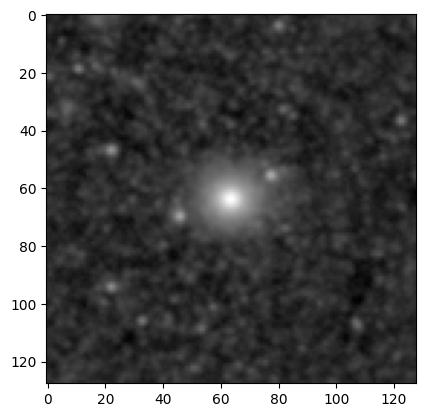

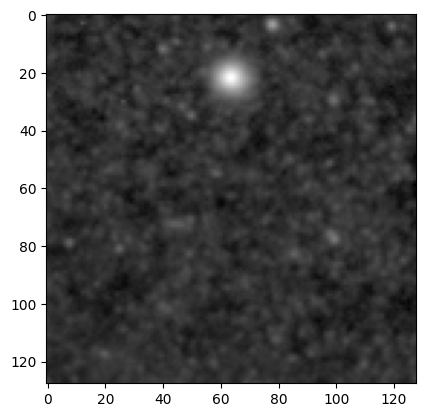

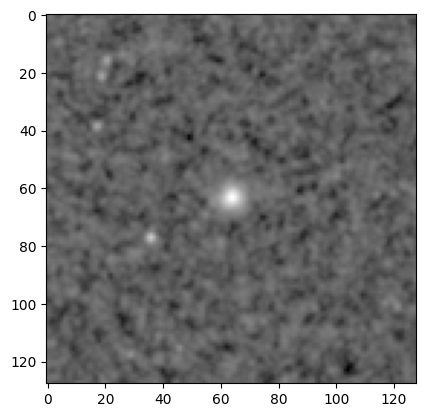

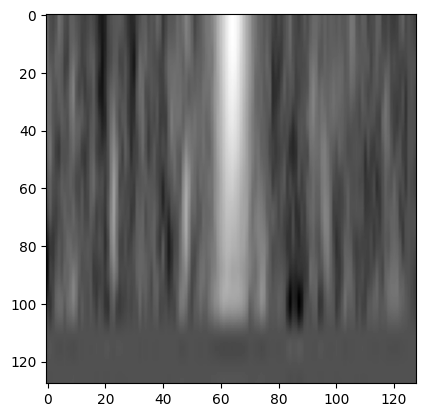

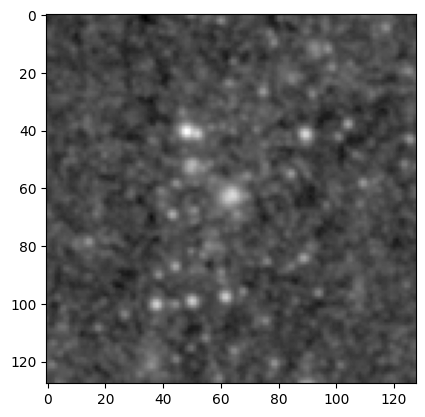

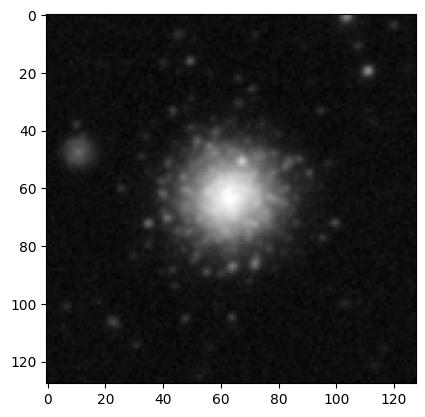

(1.0, 1.0, 0.0, 1.0, 1.0)
(1.0, 1.0, 1.0, 1.0, 1.0)
(1.0, 1.0, 0.0, 0.0, 0.0)
(1.0, 1.0, 1.0, 1.0, 0.0)
(0.0, 0.0, 1.0, 1.0, 0.0)
(1.0, 0.0, 0.0, 1.0, 1.0)
(1.0, 0.0, 1.0, 0.0, 1.0)
(1.0, 0.0, 0.0, 0.0, 0.0)
(0.0, 0.0, 1.0, 1.0, 0.0)
(1.0, 1.0, 0.0, 0.0, 1.0)
(0.0, 1.0, 0.0, 0.0, 0.0)
(1.0, 0.0, 1.0, 0.0, 0.0)
(0.0, 0.0, 0.0, 1.0, 0.0)
(0.0, 1.0, 0.0, 0.0, 0.0)
(1.0, 0.0, 1.0, 1.0, 1.0)
(1.0, 1.0, 0.0, 0.0, 0.0)
()


In [1]:
import json
import os
from astropy.io import fits 
import random
import numpy as np 
from image_utils import encode_image_to_base64


Galaxy_Dir = 'OpenAI-venv/galaxyimages'
GC_Dir = 'OpenAI-venv/gcimages'
Large_Galaxy_Dir = 'OpenAI-venv/LargeGalaxyImages'
Large_GC_Dir = 'OpenAI-venv/fitsgcs copy'
output = 'OpenAI-venv/data.json'
data = []

def load_images(path, noimages, filetype): 
    with os.scandir(path) as files:
        images = []
        nofiles = 0
        for file in files: 
            if file.name.startswith('.') or nofiles == noimages:
                continue  
            #Exeption handling if dataset contains non fits file
            try: 
                image = fits.open(file)
            except:
                continue


            data = image[0].data
            height, width = data.shape
            data = np.expand_dims(data, axis=-1)
            crop_size = 210
            start_y = (height - crop_size) // 2
            start_x = (width - crop_size) // 2

            # Crop the central 210x210 region. Using ... allows for any number of channels.
            cropped_data = data[start_y:start_y+crop_size, start_x:start_x+crop_size, ...]
            cropped_data = np.squeeze(cropped_data, axis=-1)

            # Encode the cropped image to base64
            image = encode_image_to_base64(cropped_data)

            images.append({
                "file_name": file.name,
                "metadata": {
                    "object_type" : filetype
                },
                "image_data": image
            })
            nofiles += 1 
    return (images)
data.extend(load_images(Large_Galaxy_Dir, 40, ""))
data.extend(load_images(Large_GC_Dir, 40, ""))
data_labels = list(np.zeros(40))
data_labels.extend(list(np.ones(40)))
zipped_data = list(zip(data, data_labels))
# Shuffle the zipped list
random.shuffle(zipped_data)
# Unzip them back into two separate lists
data, data_labels = zip(*zipped_data)
for i in range(0, len(data_labels)+1, 5):
    print(data_labels[i:i+5])
with open(output, "w") as json_file:
    json.dump(data, json_file, indent=4)

Call the API

In [2]:
from openai import OpenAI
import json
import os

client = OpenAI(api_key=os.getenv("OPENAI_API_KEY"))


with open("OpenAI-venv/data.json", "r") as data:
    input_data = json.load(data)
    #set my private openai key as environment variable to use here
    batch_size = 5
    for i in range(0, len(input_data), batch_size): 
        #get data for batch to send to api
        batch = input_data[i:i+batch_size]
        messages =[
            {"role": "system", "content": "You are a classifier for astronomical images from the PandAS astronomical survey. Do not use metadata or any external information to classify the images."},
            {"role": "user", "content": f"You will be shown batches of image data of either Globular Clusters (GCs) or Galaxies. The object may not be in centre of frame. A batch can contain 5 images. Please return an array of length 5 with an entry for each image in the batch. Return 1 for GC and 0 For galaxy. do no use the metadata and not give any further information: {json.dumps(batch)}"}
        ]
        response = client.chat.completions.create(model="gpt-4o-mini",
        messages = messages)
        result = response.choices[0].message.content
        print(result)

[1, 1, 0, 0, 1]
[1, 1, 0, 0, 0]
[0, 1, 1, 1, 0]
[0, 1, 0, 0, 0]
[1, 0, 0, 1, 0]
[1, 0, 0, 0, 1]
[1, 0, 0, 0, 1]
[1, 0, 0, 0, 0]
[1, 0, 0, 0, 1]
[1, 0, 1, 0, 0]
[1, 0, 0, 1, 0]
[0, 1, 0, 1, 0]
[1, 0, 0, 1, 0]
[1, 0, 0, 0, 1]
[1, 0, 0, 0, 1]


KeyboardInterrupt: 

In [ ]:
from openai import OpenAI
import json
import os

client = OpenAI(api_key=os.getenv("OPENAI_API_KEY"))


with open("OpenAI-venv/data.json", "r") as data:
    input_data = json.load(data)
    #set my private openai key as environment variable to use here
    batch_size = 5
    for i in range(0, len(input_data), batch_size): 
        #get data for batch to send to api
        batch = input_data[i:i+batch_size]
        if (i < 6):
            message =  {"role": "user", "content": f"You will be shown batches of image data of either Globular Clusters (GCs) or Galaxies. The object may not be in centre of frame. A batch can contain 5 images. The first 2 batches will then contain the correct labels. Use these to help you classify the rest.: {json.dumps(batch)} {data_labels[0:5]}. Do not respond with a message"}
        else: 
            message =  {"role": "user", "content": f"You will now be shown batches of image data of either Globular Clusters (GCs) or Galaxies. The object may not be in centre of frame. A batch can contain 5 images. Please return an array of length 5 with an entry for each image in the batch. Return 1 for GC and 0 For galaxy. do no use the metadata and not give any further information, but do use the first 2: {json.dumps(batch)}"}
        messages =[
            {"role": "system", "content": "You are a classifier for astronomical images from the PandAS astronomical survey. Do not use metadata or any external information to classify the images."}, message
        ]
        response = client.chat.completions.create(model="gpt-4o-mini",
        messages = messages)
        result = response.choices[0].message.content
        print(result)

KeyboardInterrupt: 

Calculate the resulting accuracy 

In [ ]:
from openai import OpenAI
import json
import os

client = OpenAI(api_key=os.getenv("OPENAI_API_KEY"))

# Load dataset
with open("OpenAI-venv/data.json", "r") as data:
    input_data = json.load(data)

batch_size = 5
data_labels = [1, 1, 0, 1, 1, 1, 1, 1, 1, 1]  # labels

# Prepare few-shot examples (first two batches)
few_shot_examples = []
for i in range(2):  # Only use the first 2 batches
    batch = input_data[i * batch_size : (i + 1) * batch_size]
    labels = data_labels[i * batch_size : (i + 1) * batch_size]
    
    few_shot_examples.append(
        {"role": "user", "content": f"Batch {i+1}: {batch} → Labels: {labels}"}
    )
    few_shot_examples.append(
        {"role": "assistant", "content": f"{labels}"}
    )

# Process remaining batches (avoiding token overload)
for i in range(2, len(input_data) // batch_size):  
    batch = input_data[i * batch_size : (i + 1) * batch_size]
    
    # Reset messages for each API call (only system prompt + few-shot + current batch)
    messages = [
        {"role": "system", "content": "You are a classifier for astronomical images from the PandAS survey. Do not use metadata or external sources to classify the images."}
    ] + few_shot_examples + [
        {"role": "user", "content": f"Batch {i+1}:\n{json.dumps(batch, indent=2)}\nClassify this batch. Return an array of 5 values (0 for Galaxy, 1 for GC)."}
    ]

    # Call API with reduced context size
    response = client.chat.completions.create(
        model="gpt-4o-mini",
        messages=messages
    )

    result = response.choices[0].message.content
    print(f"Batch {i+1} Prediction:", result)

BadRequestError: Error code: 400 - {'error': {'message': "This model's maximum context length is 128000 tokens. However, your messages resulted in 128381 tokens. Please reduce the length of the messages.", 'type': 'invalid_request_error', 'param': 'messages', 'code': 'context_length_exceeded'}}